In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms, models
import numpy as np 
import os
import joblib
import time
from utils import *
import matplotlib.pyplot as plt
from Resnet import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.ToTensor(),   # Convert image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
# seed 고정
set_seed(42)

In [4]:
## model resnet18 불러오기
model=resnet18(num_classes=10,pretrained=False)

In [5]:
saved_path = './saved'
state_dict_path = os.path.join(saved_path,'resnet18_weights.pth')
state_dict = torch.load(state_dict_path) # map_location='cpu' choose this if you do not have GPU
model.load_state_dict(state_dict)

C:\Users\sinse\AppData\Local\Temp\ipykernel_17176\1408264145.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path) # map_location='cpu

<All keys matched successfully>

In [6]:
# args 와 criterion에 넣기
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [7]:

def train(model,train_loader,num_epochs=10):
    model.train()
    for epochs in range(num_epochs):
        model.train()
        running_loss=0.0
        for images, labels in tqdm(train_loader):
            images,labels= images.to(device),labels.to(device)

            output=model(images)
            loss = criterion(output,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

        print(f'Epochs: {epochs+1}/{num_epochs} Training loss: {running_loss/len(train_loader)}')
        
def test(model,test_loader,howmany):
    model.eval()
    s=time.time()
    with torch.no_grad():
        total=0
        correct=0
        for images,labels in tqdm(test_loader):
            images,labels= images.to(device),labels.to(device)
            output=model(images)
            _,predicted = torch.max(output,dim=1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
        
        accuracy=100*correct/total
        e=time.time()
        print(f'Accuracy: {accuracy}%, Forward Time: {e - s:.2f}s, pruned_channel: {howmany}')
        get_model_memory_usage(model)

def get_model_memory_usage(model):
    total_params = 0
    total_memory = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            total_memory += param.numel() * param.element_size()  # Bytes

    print(f"Total Parameters: {total_params}")
    print(f"Memory Usage for Parameters: {total_memory / 1e6:.2f} MB")  # Convert to MB

### Structured pruning for CNN 은 2가지로 구분된다
1. CNN (연산속도)-> 학습된 모델에 sentiment analysis 요구 (Filter, )
2. FN (파라미터) 

In [8]:
#sensitivity analysis
        
sensitivity_layer= sensitivity_check(model)

### sensitivity CNN 시각화

In [9]:

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


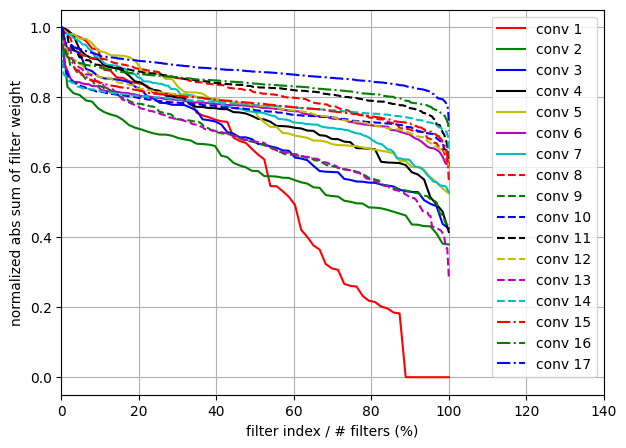

In [10]:
plt.figure(figsize=(7,5))
count=0
for key,sensitivity in sensitivity_layer.items():
    line_style=colors[count%len(colors)]+lines[count//len(colors)]
    x=np.linspace(0,100,num=sensitivity.shape[0])
    y=sensitivity
    count+=1
    print(count)
    plt.plot(x,y,line_style,label='conv %d'%count)
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.show()        

### prune 하기

In [11]:
max_ratio=0.9
step_ratio=8

In [12]:
idx2name_module={}
i=0
for name,module in model.named_modules():
    if isinstance(module,nn.Conv2d) and 'downsample' not in name:
        idx2name_module[i]=(name,module)
        i+=1
    elif isinstance(module,nn.BatchNorm2d) and 'downsample' not in name:
        idx2name_module[i]=(name,module)
        i+=1
    elif isinstance(module,nn.Linear):
        idx2name_module[i]=(name,module)
        i+=1

In [13]:
idx2name_module

{0: ('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 1: ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 2: ('layer1.0.conv1',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 3: ('layer1.0.bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 4: ('layer1.0.conv2',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 5: ('layer1.0.bn2',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 6: ('layer1.1.conv1',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 7: ('layer1.1.bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 8: ('layer1.1.conv2',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 9: ('layer1.1.bn2',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [14]:
from prune_function import *
from prune import *
import copy
idx=0
for name,module in model.named_modules():
    if isinstance(module,nn.Conv2d) and 'downsample' not in name:
        step=np.linspace(0,int(module.out_channels*max_ratio),step_ratio,dtype=int)
        steps=step[1:]-step[:-1]
        # steps는 얼마만큼의 filter를 제거할꺼인지 정함.
        for i in range(len(steps)): 
            # 매번 필터를 제거하는양이 달라서 network부름
            network=copy.deepcopy(model) # TODO: fix
            num_channel=module.out_channels- sum(steps[:i+1])
            print(name,sum(steps[:i+1]))
            network=prune_step(network,name,num_channel,idx2name_module,index=idx)
            network=network.to(device)
            print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
            print(network)
            
            network_name_v='resenet'+'_'+ name +'_'+str(sum(steps[:i+1]))+'.joblib'
            network_name=os.path.join(saved_path,network_name_v)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            ## 이것도 안되면 새로추가된 부분에 조금더 lr 다르게 부여해보자.
            # train(network,train_loader,num_epochs=5)
            # joblib.dump(network,network_name)
            test(network,test_loader,sum(steps[:i+1]))
        idx+=2
                
         

conv1 8
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 56, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(56, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


Accuracy: 36.85%, Forward Time: 10.12s, pruned_channel: 8
Total Parameters: 11179426
Memory Usage for Parameters: 44.72 MB
layer1.0.conv1 8
layer1.0.conv1 layer1.0.conv2 tensor([ 9, 40, 20,  6,  2, 13, 28, 50, 45, 46, 39, 60, 12, 34,  1,  7, 22, 42,
        58, 14, 15, 54, 36, 19, 26,  0, 37, 63, 33,  3, 49,  5,  4, 35, 27, 41,
        53, 10, 31, 38, 18, 57,  8, 43, 16, 23, 47, 17, 48, 21, 59, 52, 24, 51,
        61, 11])
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(56, eps=1e-05, momentum=0.1, af

100%|██████████| 79/79 [00:09<00:00,  7.99it/s]


Accuracy: 95.65%, Forward Time: 9.89s, pruned_channel: 8
Total Parameters: 11172410
Memory Usage for Parameters: 44.69 MB
layer1.0.conv2 8
layer1.0.conv2 layer1.1.conv1 tensor([11, 46, 63, 50, 56, 21, 29, 19, 49, 38, 51, 26, 48, 57, 14, 20, 17,  7,
         3, 12, 43, 22, 62, 58, 60, 28, 54, 30, 40, 25, 42, 53,  5,  8, 10, 31,
         0, 44,  4, 59, 47, 55, 32, 33, 34, 27, 45, 23, 39,  1, 41, 36, 16, 37,
         2, 15])
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


Accuracy: 13.34%, Forward Time: 10.05s, pruned_channel: 8
Total Parameters: 11179578
Memory Usage for Parameters: 44.72 MB
layer1.1.conv1 8
layer1.1.conv1 layer1.1.conv2 tensor([16, 11, 49,  7, 55, 36, 51, 29, 35, 25,  9, 50, 10, 61, 13, 47, 21, 31,
        59, 38, 14,  5,  2, 39, 56,  8, 44, 23, 43, 45, 52, 58,  0, 27, 60,  1,
        32, 63, 41, 54,  4, 33, 19, 62, 15,  6, 26, 48, 40, 53, 57, 37, 12,  3,
        34, 18])
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


Accuracy: 95.78%, Forward Time: 9.88s, pruned_channel: 8
Total Parameters: 11172410
Memory Usage for Parameters: 44.69 MB
layer1.1.conv2 8
layer1.1.conv2 layer2.0.conv1 tensor([50, 58, 40, 63, 22, 11, 17,  8, 48, 43, 36, 38, 46, 28, 12, 39, 20,  7,
        49, 37, 42, 30, 52, 44, 51, 29, 56, 54,  3, 32, 21, 59, 13, 47, 14,  2,
        34, 62, 33,  5, 23, 19,  6, 18, 16, 55,  4,  1, 31, 60, 26,  0, 53, 57,
        45, 15])
isintance 는들어오는거네?
g
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-

100%|██████████| 79/79 [00:09<00:00,  7.96it/s]


Accuracy: 15.23%, Forward Time: 9.92s, pruned_channel: 8
Total Parameters: 11170362
Memory Usage for Parameters: 44.68 MB
layer2.0.conv1 16
layer2.0.conv1 layer2.0.conv2 tensor([ 17, 113,  13,  29,  46,  69, 115,  74,  19, 101,  96, 102,  86, 106,
         76,  16,  25,  20,  68,  48, 122,  38,  15, 117,  67,   3,  97, 116,
         37, 121, 105,  28,  51, 125,  98,  95,  66,  55,  90, 126,  81,  89,
        123,  87,  92,  50,  73,  91,  24,   7,   1,  39,  70,  63,  54,   2,
        109,  21,  22,  65,  99,  18,  80,  34,  49,  82, 124,  94,  23,  75,
          9,  77,  36,  59, 111,   6, 108,  93,  45, 100,  88, 119, 104,  27,
         31,  33,  32,  61, 120,  78,  43,  56,  79,  10,   8,  85,  53,  35,
         52, 127,  83,   4,   5, 114,  47,  60,  44,  12, 118,  26,  64, 103])
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-

100%|██████████| 79/79 [00:09<00:00,  8.05it/s]


Accuracy: 94.89%, Forward Time: 9.82s, pruned_channel: 16
Total Parameters: 11153962
Memory Usage for Parameters: 44.62 MB
layer2.0.conv2 16
layer2.0.conv2 layer2.1.conv1 tensor([ 87,  99,  40,  64,  95,  30,  66, 107,  39,  81,  23,  82,  54,  48,
         31,  77,  63,  71, 117, 111, 120,   1,  25,  91, 125,  52, 105,   6,
         62, 100, 106,  51,  74,   9,  79, 113,   2,  96,  73,  32,  88,   8,
         49, 102,  58, 123,  61, 118,  72,   5,  36,  11,  92,  19, 124,  21,
         86,  41,  89,  69,  80, 116, 122,  67,  38,  83,  29,  68, 108, 121,
        112,  33, 127,   7,  84,   4,  75, 103, 115,  26,  76,  13,  59,  93,
         60,  18,  35,  37,  10, 101, 110,  16,  56,  45,  98,  17,  24,  65,
         90,  15,  47,  34,  22, 119,  20, 109,  85,  55, 126,  14,  44,  53])
isintance 는들어오는거네?
yes
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1):

100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


Accuracy: 12.47%, Forward Time: 10.05s, pruned_channel: 16
Total Parameters: 11158026
Memory Usage for Parameters: 44.63 MB
layer2.1.conv1 16
layer2.1.conv1 layer2.1.conv2 tensor([ 29,  55, 116,  48,  31,  82,  42,  17,  59,  68,  79, 121,  58,  73,
         56, 125,  20, 120,  77, 126,  24,  57,  75,  40,  49,  16,  99,  34,
         61,   3, 115, 119,  52, 122,   5, 108,  45,  81,  51,  71,   0, 110,
         66, 123,   9,  74,  70,   8,  89, 102,  90, 127,  64,  11,  21,  36,
         88,  23,   7,  87, 104,  86, 101, 105,  95,  85, 103,  93,  50,  14,
         43,  69,  26,  13,  94,  83, 107,  96,  25,  78, 124,  72,  98,  12,
        100,  53,  97,  54,  62,  22, 106,  76,  18,  92,   4,  63,  80,  91,
         37,  44,  35, 114,  67,  30,  39,  84, 112,   6,   2, 117,  47,  46])
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1

100%|██████████| 79/79 [00:10<00:00,  7.84it/s]


Accuracy: 95.44%, Forward Time: 10.08s, pruned_channel: 16
Total Parameters: 11144746
Memory Usage for Parameters: 44.58 MB
layer2.1.conv2 16
layer2.1.conv2 layer3.0.conv1 tensor([ 35,  76, 118,   5,  69, 124,  48,  60,  21,  72,  81, 113,  41,  91,
         67,  71,  92,  73,  36,  23,  62,  98, 110,  25,  86,  58,  51,  52,
        106, 116,  19,  88,  79,  95,  31,   6, 125, 122, 109, 127, 108,   2,
         37,  87,  30,  49, 105,   9,  24,  10,  75, 115,  29, 112,  84,  13,
          8,  32, 119,  90,  99,  54,   4,  83, 103,  28,  68,  96,  66, 100,
         80,  15,  59,  22,  40,  61, 111,  63,  14,  38,  77,  34,  26,  64,
         74, 117,  93, 101,  56,  18,  42,  33,  16, 114,  17,  39,  55,   7,
        107,  53, 102, 120,   3,  45,  44,  11, 126,  46,  94,  97, 104,  78])
isintance 는들어오는거네?
g
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): 

100%|██████████| 79/79 [00:10<00:00,  7.89it/s]


Accuracy: 15.12%, Forward Time: 10.01s, pruned_channel: 16
Total Parameters: 11136554
Memory Usage for Parameters: 44.55 MB
layer3.0.conv1 32
layer3.0.conv1 layer3.0.conv2 tensor([202, 195,  98, 212,  12, 164,   2, 205, 110, 180,  14, 115,  53, 108,
         51, 179,  24, 138, 114, 120, 155, 172,  21,   5,  95,  36,   9, 228,
        131,  68, 207, 186,  49,  90, 113, 220,   8,  26,  84, 132,  13, 141,
         81, 143, 241, 125,  46,  10, 105, 221, 233, 219, 215, 149, 162,  94,
        251,  57, 244,  48, 100, 128,  17,  64, 216, 134, 217,  32, 250,  38,
        122,  88, 201,  45,  41,  23,  60,  62,  20, 107,  47, 197, 146, 130,
         65, 218,  44,  27, 106,  91, 252,  89, 158, 255,   6, 171, 187, 139,
        102,  87, 230, 118, 147, 136,  34, 168, 169,  50,  25,  79,  30, 151,
        247,  74, 214, 160,  55,  39, 145,   1,  22,  52, 111, 170, 182, 103,
         15, 161, 159, 157,  85, 166,  35,  78, 246,  92,  96, 101, 238,  59,
          7, 234,  71, 178,  70, 121, 185,  33, 

100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


Accuracy: 94.67%, Forward Time: 9.80s, pruned_channel: 32
Total Parameters: 11070986
Memory Usage for Parameters: 44.28 MB
layer3.0.conv2 32
layer3.0.conv2 layer3.1.conv1 tensor([109,  22, 128,  71, 216, 197, 104, 106, 100, 210, 245, 214, 217,  66,
         70,  61, 141, 137,  98, 115, 238, 177,   7, 201,  95,   8,  76, 222,
         33, 239, 194, 240, 186, 244, 211,  55, 190,  67, 173, 135, 234,  90,
        225, 149, 168,  10, 102, 142, 123,  85,   9, 228, 130,  73, 191, 166,
         45, 111, 103, 250, 226, 108,  16, 230,  23, 122, 200, 136, 129, 215,
         37,  42,  27,  93,  69,  46, 204,  63,  38,  64,  28,  99, 132, 153,
        189,  65, 133,  25,  57,  82,  84, 229,   0, 143,  62, 205,  59,  72,
        140, 218,  74,  79, 236,  40,  56, 184, 253, 237, 118,  91,  26,  32,
         35,  86,  83, 138,  13, 125, 179, 202, 155,  94, 162, 151,  48,  87,
        247, 246, 224,  78,  77,  19,  11, 107, 243, 209,  97, 223, 165,  75,
        255,  51, 203,  34, 178, 147, 249,  81, 1

100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Accuracy: 38.24%, Forward Time: 10.34s, pruned_channel: 32
Total Parameters: 11087306
Memory Usage for Parameters: 44.35 MB
layer3.1.conv1 32
layer3.1.conv1 layer3.1.conv2 tensor([ 54,   7, 150, 254,  51, 235, 136,  65,  41, 168, 225, 184, 153,  88,
         87,  78,  19, 191, 128, 157, 160, 110, 216,  95, 133, 228,  68, 227,
         70, 245, 214,  48,  34,  29, 188, 199,  31,  77, 240, 161, 192, 205,
        142, 252,  75,  80, 173, 248, 147, 118, 212, 186, 208, 166, 224, 132,
        190,  21, 250,  55, 189, 138, 202, 185, 220,   4, 120, 108, 165,  76,
          1,  40,  24, 170, 197, 121, 124, 111,  14,  28, 181, 178,  35, 200,
        238,  85, 100, 255,  47,  86,   9, 196, 232, 125, 139, 154,  25,  18,
         96, 217,  98, 222,  50, 194, 244, 247,  93, 201, 129,  59, 169,   5,
        179,  92,  99,  79, 193,  46,  13, 145, 164, 115, 126, 231, 219, 144,
         11, 182,   3,  22,  23, 229, 162, 130,  32, 242, 233, 218, 253, 167,
        137, 103, 180, 206, 109,  82,  57, 249, 

100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Accuracy: 95.67%, Forward Time: 10.15s, pruned_channel: 32
Total Parameters: 11034122
Memory Usage for Parameters: 44.14 MB
layer3.1.conv2 32
layer3.1.conv2 layer4.0.conv1 tensor([ 21, 205, 248, 188, 167, 117, 163, 199, 108, 141, 214,  86, 100, 128,
        158,  27, 122, 200, 196, 169,  66, 149, 120, 187, 155, 112, 250, 170,
        229, 144,  88, 252,  19,  12, 220, 180, 181, 137,  14,  22, 226, 189,
        198, 204,  23,  92, 215, 225, 114,  29,  52,  16, 135,  64, 153,  15,
         18, 242, 173, 166, 126, 182, 119, 150,  99, 246,  69,  63, 192,  25,
         77, 175, 121,  91, 168, 184, 203, 178, 206,   0, 213, 247, 233, 216,
         94,  13,  98,  47, 179,  53, 209, 146, 124, 154, 183,  59,  49,  20,
        207, 107,  17, 231,  83, 161,  40, 165, 234, 118, 145,  48, 147, 101,
        253,  74,  32, 133, 232,  82, 177,  96, 164, 113,  67,  75,  51, 223,
         80, 221, 228,  58,   6,  35, 190, 123, 218, 172,  93,  89, 255, 201,
        106,   7,  55, 174,  95,  41, 240,  70, 

100%|██████████| 79/79 [00:10<00:00,  7.76it/s]


Accuracy: 34.46%, Forward Time: 10.18s, pruned_channel: 32
Total Parameters: 11001354
Memory Usage for Parameters: 44.01 MB
layer4.0.conv1 65
layer4.0.conv1 layer4.0.conv2 tensor([260, 462, 393, 507, 467,  36,  17, 193, 168, 432, 386, 261, 274,  57,
          3, 429, 445, 210, 203, 509, 126, 122, 352, 368, 215, 202, 201, 162,
        316, 384, 410, 395, 374,  41, 306,   9, 245, 489, 390, 172, 408, 161,
        447, 355, 511, 209, 434, 277, 244,  19, 296, 482, 321, 404, 425,  76,
        114,  12,  29,  45, 119, 164, 475, 391, 181, 270, 329,  21, 128,  31,
        238, 322, 273, 508, 271, 362, 310, 389, 189, 141, 427, 502, 487, 422,
         46, 498, 133, 233, 420, 479, 387, 396, 156, 373, 308, 199, 439, 147,
        278, 196, 424, 312, 276, 499,  59, 438,   4, 366, 503, 183, 405, 459,
        358, 249,  40, 469, 435, 451, 333, 185, 381, 194,  44,  24,  93, 464,
        490, 342, 452, 143, 207, 284, 476,  69,  43,  98, 440, 359, 402, 437,
        407,   5, 327, 195,  71, 326, 134, 257, 

100%|██████████| 79/79 [00:10<00:00,  7.71it/s]


Accuracy: 95.56%, Forward Time: 10.25s, pruned_channel: 65
Total Parameters: 10732232
Memory Usage for Parameters: 42.93 MB
layer4.0.conv2 65
layer4.0.conv2 layer4.1.conv1 tensor([372, 237, 341, 233, 430, 319, 418,  13, 153, 241, 239, 245, 219, 349,
        346, 274, 284, 164, 345, 267, 324, 126, 494, 244,  44, 200, 148, 479,
         67, 271, 289, 489, 466, 343, 332,  84, 403, 211, 330, 463, 407, 433,
        366, 102, 336, 229,  31, 440, 442, 373, 277, 468, 242, 477, 474, 452,
        378, 240, 160, 125, 206,  45, 116,  36,   0, 427, 368, 446, 212, 311,
         91, 170, 410,  99, 114, 326, 511,  25, 197, 107,   9, 236,  21, 115,
         42, 409,   6, 296,  53, 333, 329, 260, 186, 282, 302, 429, 316,  47,
        301, 122, 162,  61, 179, 441, 439, 220, 445, 499,  83, 201,  62, 270,
         63, 462, 470, 279, 121, 472, 327, 155, 269, 306, 340, 280, 361, 231,
        150, 145, 399, 189, 492, 509, 398,   4, 108,  70, 473, 218, 287, 249,
        453, 181,  88, 371, 320, 469, 182, 283, 

100%|██████████| 79/79 [00:10<00:00,  7.75it/s]


Accuracy: 95.36%, Forward Time: 10.19s, pruned_channel: 65
Total Parameters: 10794566
Memory Usage for Parameters: 43.18 MB
layer4.1.conv1 65
layer4.1.conv1 layer4.1.conv2 tensor([ 87, 503, 431, 460,  71,  53,  91, 481,  17, 492,  94, 106, 226, 205,
        452, 398, 354, 135, 225, 404, 342, 274, 364, 345, 208, 142, 278, 410,
        405, 428,  33, 277,  78, 378, 244, 282, 184, 498, 335, 458, 236, 343,
        165,  72, 448, 116, 386, 299,  82, 153,  29, 475, 110,  56,  36, 306,
        495, 177,  58, 476,  95, 325, 388, 317,  96, 287, 187, 507, 406,  59,
        484, 310, 316, 312, 329, 392, 280, 470,  24, 104, 201, 243,  41, 425,
        338, 294, 267, 206, 408, 162, 266, 250, 298, 273, 453, 456, 341, 262,
          3, 180, 163, 265, 272, 224, 114, 230, 362,  76, 347,  73,  79, 157,
        497, 122, 320,  11, 369, 300,  97, 324,   1,   4,  52,  85, 229, 235,
        176, 195, 432, 246, 418,  28, 103, 359, 482, 268,  98, 372, 111,  92,
        231, 152, 501,  49, 175,  44, 131, 360, 

100%|██████████| 79/79 [00:09<00:00,  7.92it/s]


Accuracy: 95.35%, Forward Time: 9.98s, pruned_channel: 65
Total Parameters: 10582472
Memory Usage for Parameters: 42.33 MB
layer4.1.conv2 65
layer4.1.conv2 fc tensor([164, 117,   7, 242, 361, 239, 106,  17, 431, 507, 237, 186, 485, 427,
        457, 257, 448, 185, 135,  47, 192, 338, 261, 460, 468,   1, 364, 415,
        258, 385, 435, 372,   8, 484, 400, 506, 312, 334, 378, 219,  22, 502,
        486, 430, 255, 161, 226, 434, 119,  63, 286, 426, 368, 246, 272,  81,
        120, 156,  91,  93, 129, 296, 319, 488,  83,  23,  70, 331, 155, 260,
        101, 182,   2, 440, 479, 147, 429, 498,  24, 360, 437, 134, 220,   6,
        193, 357,  50, 367, 466, 343,  45,  36, 278, 332,   3, 384, 254, 274,
         65, 152, 201, 295, 380, 209, 382, 148, 198, 100, 481,  58, 399, 452,
        230, 490, 165, 405, 316, 176, 383,  95,  26, 202, 339, 151, 250, 458,
        204, 280, 144, 465, 244, 349, 233, 322, 235, 487, 394, 306, 103,  59,
        157, 107,   9, 276, 464, 231, 294, 304, 395, 109, 236

100%|██████████| 79/79 [00:10<00:00,  7.82it/s]

Accuracy: 95.76%, Forward Time: 10.11s, pruned_channel: 65
Total Parameters: 11110206
Memory Usage for Parameters: 44.44 MB


In [18]:
network.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 447, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(447, eps=1